<a href="https://colab.research.google.com/github/himanshu-tawra/COVID-19-Detector-Flask-App-from-Chest-X-ray-Images-with-Keras-and-Deep-Learning/blob/master/VGG16_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.applications.vgg16 import VGG16
import keras

In [4]:
IMAGE_SIZE = [224,224]

In [5]:
vgg = VGG16(input_shape= IMAGE_SIZE + [3] , weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [6]:
for layer in vgg.layers:
  layer.trainable = False

In [7]:
vgg_output = vgg.output

In [8]:
flatten = Flatten()(vgg_output)
Dense_layer1 = Dense(units = 256,activation=keras.layers.LeakyReLU(alpha=0.3))(flatten)
Dense_layer2 = Dense(units=128,activation=keras.layers.LeakyReLU(alpha=0.3))(Dense_layer1)
Dense_layer3 = Dense(units = 64,activation=keras.layers.LeakyReLU(alpha=0.3))(Dense_layer2)
output_layer = Dense(3,activation='softmax')(Dense_layer3)

In [9]:
model = Model(inputs = vgg.input,outputs = output_layer)

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(0.000001),  # Low learning rate
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [12]:
training_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [13]:
val_data_gen = ImageDataGenerator(
    rescale = 1./255.
)

In [14]:
training_set = training_data_gen.flow_from_directory(
    '/content/drive/My Drive/Data/train/',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = 32
)

Found 1380 images belonging to 3 classes.


In [15]:
val_set = val_data_gen.flow_from_directory(
    '/content/drive/My Drive/Data/test/',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = 32
)

Found 353 images belonging to 3 classes.


In [16]:
from keras.callbacks import ModelCheckpoint
callback_list = [ModelCheckpoint('vgg_16.h5', monitor='val_loss', verbose=True, save_best_only=True)]

In [17]:
r = model.fit(
    training_set,
    epochs = 100,
    validation_data = val_set,
    validation_steps = len(val_set),
    steps_per_epoch = len(training_set),
    callbacks = callback_list
)

Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 1.0531 - accuracy: 0.4870
Epoch 00001: val_loss improved from inf to 1.01763, saving model to vgg_16.h5
44/44 [==============================] - 528s 12s/step - loss: 1.0531 - accuracy: 0.4870 - val_loss: 1.0176 - val_accuracy: 0.5439
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.9803 - accuracy: 0.6529
Epoch 00002: val_loss improved from 1.01763 to 0.94512, saving model to vgg_16.h5
44/44 [==============================] - 68s 2s/step - loss: 0.9803 - accuracy: 0.6529 - val_loss: 0.9451 - val_accuracy: 0.6771
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.7667
Epoch 00003: val_loss improved from 0.94512 to 0.87537, saving model to vgg_16.h5
44/44 [==============================] - 68s 2s/step - loss: 0.9006 - accuracy: 0.7667 - val_loss: 0.8754 - val_accuracy: 0.7535
Epoch 4/100
44/44 [==============================] - ETA: 0s - loss: 0.8349 - accura

In [18]:
test_pred = []
test_actual = []
train_pred = []
train_actual = []
label_dict = {
    0 : "Covid",
    1 : "Normal",
    2 : "Pneumonia"
}
train_covid_path = '/content/drive/My Drive/Data/train/COVID19'
train_normal_path = '/content/drive/My Drive/Data/train/NORMAL'
train_pneumonia_path = '/content/drive/My Drive/Data/train/PNEUMONIA'


covid_path = '/content/drive/My Drive/Data/test/COVID19'
normal_path = '/content/drive/My Drive/Data/test/NORMAL'
pneumonia_path = '/content/drive/My Drive/Data/test/PNEUMONIA'

In [19]:
model.evaluate_generator(training_set,steps = 32,verbose = 1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
32/32 [==============================] - 43s 1s/step - loss: 0.1123 - accuracy: 0.9717


[0.1122966930270195, 0.9716796875]

In [20]:
model.evaluate_generator(val_set,steps = 32, verbose = 1)

12/32 [==========>...................] - 10s 860ms/step - loss: 0.1455 - accuracy: 0.9377


[0.14552749693393707, 0.9376770257949829]

In [21]:
def image_preprocessing(test_image):
  image_array = image.img_to_array(test_image)
  image_array = np.expand_dims(image_array,axis = 0)
  rescaled_image = image_array/255. 
  return rescaled_image

def predict_image(path):
  for filename in os.listdir(path):
    filepath = os.path.join(path,filename)
    test_image = image.load_img(filepath,target_size=(224,224))
    rescaled_image = image_preprocessing(test_image)


    predicted_image = model.predict(rescaled_image)
    predicted_image = predicted_image.argmax()
    if path == train_covid_path:
      train_pred.append(predicted_image)
      train_actual.append(0)
    elif path == covid_path:
      test_pred.append(predicted_image)
      test_actual.append(0)
    elif path == train_normal_path:
      train_pred.append(predicted_image)
      train_actual.append(1)
    elif path == normal_path:
      test_pred.append(predicted_image)
      test_actual.append(1)
    elif path == train_pneumonia_path:
      train_pred.append(predicted_image)
      train_actual.append(2)
    elif path == pneumonia_path:
      test_pred.append(predicted_image)
      test_actual.append(2)

In [22]:

predict_image(train_covid_path)
predict_image(train_normal_path)
predict_image(train_pneumonia_path)

predict_image(covid_path)
predict_image(normal_path)
predict_image(pneumonia_path)

In [23]:
test_pred = np.array(test_pred)
test_actual = np.array(test_actual)


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
testing_confusion_mat = confusion_matrix(test_actual,test_pred)
training_confusion_mat = confusion_matrix(train_actual,train_pred)
print(testing_confusion_mat)
print(training_confusion_mat)

[[115   1   0]
 [  0 113   3]
 [  1  17 103]]
[[456   3   1]
 [  0 459   1]
 [  4  51 405]]


In [25]:
import matplotlib.pyplot as plt

In [26]:
def plot_confusion_matrix(confusion_mat,fig_name):

  classes = ['COVID','NORMAL','PNEUMONIA']
  tick_marks = [0.5,1.5,2.5]
  sns.heatmap(confusion_mat,cmap='plasma',annot=True,linewidth = 2,fmt = 'd')

  plt.xticks(tick_marks, classes,rotation ='vertical')
  plt.yticks(tick_marks, classes,rotation ='vertical')
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(fig_name + '.png')
  plt.margins(0.2) 

  plt.show()

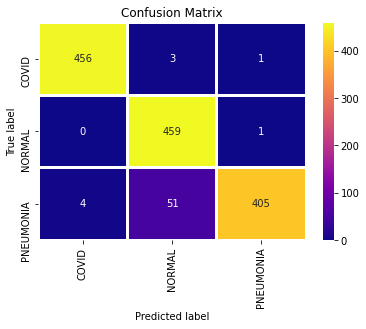

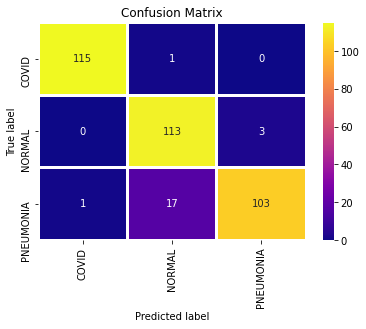

In [27]:

plot_confusion_matrix(training_confusion_mat,'Training_Confusion_Matrix')
plot_confusion_matrix(testing_confusion_mat,'Testing_Confusion_Matrix')

In [28]:

from sklearn.metrics import classification_report
print(classification_report(train_actual, train_pred,labels = [0,1,2],target_names=["Covid","Normal","Pneumonia"]))
print(classification_report(test_actual, test_pred,labels = [0,1,2],target_names=["Covid","Normal","Pneumonia"]))

              precision    recall  f1-score   support

       Covid       0.99      0.99      0.99       460
      Normal       0.89      1.00      0.94       460
   Pneumonia       1.00      0.88      0.93       460

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380

              precision    recall  f1-score   support

       Covid       0.99      0.99      0.99       116
      Normal       0.86      0.97      0.91       116
   Pneumonia       0.97      0.85      0.91       121

    accuracy                           0.94       353
   macro avg       0.94      0.94      0.94       353
weighted avg       0.94      0.94      0.94       353



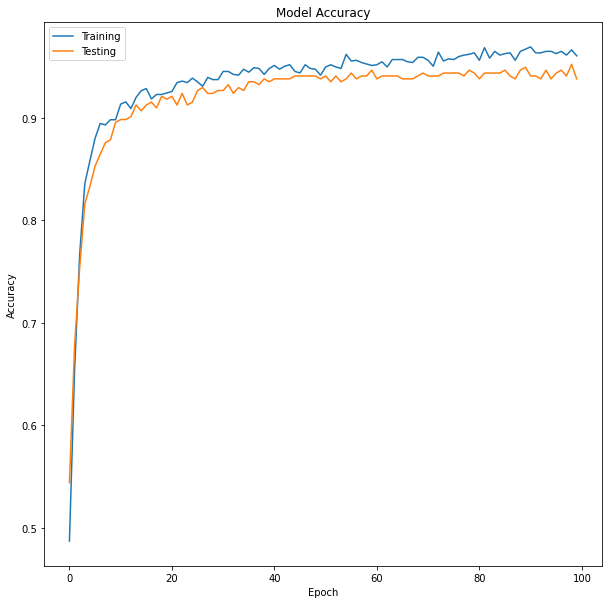

In [29]:
plt.figure(figsize=(10,10))

plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg16_chest_accuracy.png')
plt.show()

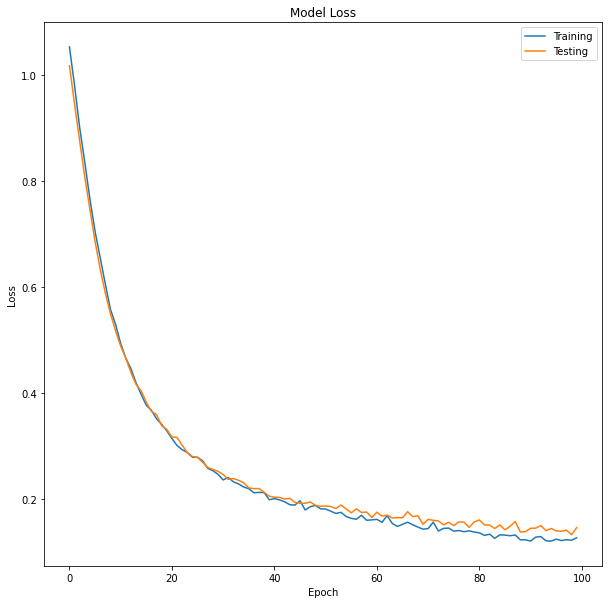

In [30]:

plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg16_chest_loss.png')
plt.show()

In [ ]:
print(np.array(test_actual).shape)

(353,)


In [ ]:
print(train_pred)

['Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 

In [ ]:
model.save('final_xception_model.h5')